# 08 Forcasting Churn

In [1]:
import json
import sqlalchemy
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint
from typing import Tuple, List, Dict

In [2]:
# Make a sql connection with sqlalchmey
conn_string = "postgresql://postgres-db/churn?user=postgres&password=password" 
engine = sqlalchemy.create_engine(
    conn_string, connect_args={'options': '-csearch_path={}'.format("socialnet7,public")}
)
conn = engine.connect()
# conn.close()

# Query with Pandas, e.g. list all tables
tables = pd.read_sql_query("SELECT * FROM information_schema.tables;", conn)
tables.head(3)

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,churn,socialnet7,active_period,BASE TABLE,None,None,None,None,None,YES,NO,None
1,churn,socialnet7,event_type,BASE TABLE,None,None,None,None,None,YES,NO,None
2,churn,socialnet7,metric_name,BASE TABLE,None,None,None,None,None,YES,NO,None


In [4]:
with open("/app/fightchurn/listings/conf/socialnet7_listings.json", "r") as f: 
    conf = json.loads(f.read())
    # conf = Box(json.loads(f.read()))

chap10 = conf["chap10"]

## Dependent Data

In [5]:
tmp = pd.read_sql_query("SELECT * FROM observation", conn)
tmp.head()

,account_id,observation_date,is_churn
0,11355,2020-04-25,False
1,5072,2020-03-16,False
2,6938,2020-04-27,False
3,1817,2020-04-14,True
4,7033,2020-04-06,True


In [6]:
tmp = pd.read_sql_query("SELECT * FROM metric_name ORDER BY metric_name_id", conn)
tmp.tail()

,metric_name_id,metric_name
16,28,unfriend_per_newfriend_scaled
17,30,new_friends_pcnt_change
18,31,days_since_newfriend
19,33,unfriend_28day_avg_84day_obs
20,34,unfriend_28day_avg_84day_obs_scaled


In [7]:
tmp = pd.read_sql_query("SELECT * FROM metric ORDER BY RANDOM() LIMIT 10000", conn)
tmp.head()

,account_id,metric_time,metric_name_id,metric_value
0,8726,2020-04-19,26,64.000000
1,756,2020-02-09,7,10.000000
2,2316,2020-04-12,3,23.000000
3,8924,2020-04-19,27,0.180124
4,7453,2020-05-03,30,-1.000000


In [8]:
tmp = pd.read_sql_query("SELECT * FROM account", conn)
tmp.head()

,id,channel,date_of_birth,country
0,1,appstore1,1999-08-30,CN
1,2,web,1952-02-10,None
2,3,appstore1,1982-03-23,CN
3,4,appstore1,2004-05-19,CA
4,5,web,1987-04-01,AU


## Metric Queries

### Listing 10.1 Demographic Observations

In [9]:
from_yyyy_mm_dd = chap10["list1"]["params"]["%from_yyyy-mm-dd"] 
to_yyyy_mm_dd = chap10["list1"]["params"]["%to_yyyy-mm-dd"]
metric_interval = chap10["list1"]["params"]["%metric_interval"]
from_yyyy_mm_dd, to_yyyy_mm_dd, metric_interval

('2020-03-01', '2020-05-10', '7 day')

In [10]:
# listing_10_1_dataset3.sql

query = f"""\
WITH observation_params AS ( 
    SELECT  
        interval '{metric_interval}' AS metric_period, 
        '{from_yyyy_mm_dd}'::timestamp AS obs_start, 
        '{to_yyyy_mm_dd}'::timestamp AS obs_end
)

    SELECT 
        m.account_id, 
        o.observation_date, 
        is_churn, 
        a.channel, 
        a.country,
        DATE_PART('day',o.observation_date::timestamp - a.date_of_birth::timestamp)::float/365.0 AS customer_age,
        SUM(CASE WHEN metric_name_id=0 THEN metric_value ELSE 0 END) AS like_per_month,
        SUM(CASE WHEN metric_name_id=1 THEN metric_value ELSE 0 END) AS newfriend_per_month,
        SUM(CASE WHEN metric_name_id=2 THEN metric_value ELSE 0 END) AS post_per_month,
        SUM(CASE WHEN metric_name_id=3 THEN metric_value ELSE 0 END) AS adview_per_month,
        SUM(CASE WHEN metric_name_id=4 THEN metric_value ELSE 0 END) AS dislike_per_month,
        SUM(CASE WHEN metric_name_id=34 THEN metric_value ELSE 0 END) AS unfriend_per_month,
        SUM(CASE WHEN metric_name_id=6 THEN metric_value ELSE 0 END) AS message_per_month,
        SUM(CASE WHEN metric_name_id=7 THEN metric_value ELSE 0 END) AS reply_per_month,
        SUM(CASE WHEN metric_name_id=21 THEN metric_value ELSE 0 END) AS adview_per_post,
        SUM(CASE WHEN metric_name_id=22 THEN metric_value ELSE 0 END) AS reply_per_message,
        SUM(CASE WHEN metric_name_id=23 THEN metric_value ELSE 0 END) AS like_per_post,
        SUM(CASE WHEN metric_name_id=24 THEN metric_value ELSE 0 END) AS post_per_message,
        SUM(CASE WHEN metric_name_id=25 THEN metric_value ELSE 0 END) AS unfriend_per_newfriend,
        SUM(CASE WHEN metric_name_id=27 THEN metric_value ELSE 0 END) AS dislike_pcnt,
        SUM(CASE WHEN metric_name_id=30 THEN metric_value ELSE 0 END) AS newfriend_pcnt_chng,
        SUM(CASE WHEN metric_name_id=31 THEN metric_value ELSE 0 END) AS days_since_newfriend
      FROM 
        metric AS m 
INNER JOIN 
        observation_params 
        ON metric_time BETWEEN obs_start AND obs_end
INNER JOIN 
        observation AS o 
        ON m.account_id = o.account_id
       AND m.metric_time > (o.observation_date - metric_period)::timestamp
       AND m.metric_time <= o.observation_date::timestamp
INNER JOIN 
        account AS a 
        ON m.account_id = a.id
  GROUP BY 
        m.account_id, 
        metric_time, 
        observation_date, 
        is_churn, 
        a.channel, 
        date_of_birth, 
        country
  ORDER BY 
        observation_date,
        m.account_id
"""

res = pd.read_sql_query(query, conn)
res.head()

,account_id,observation_date,is_churn,channel,country,customer_age,like_per_month,newfriend_per_month,post_per_month,adview_per_month,...,message_per_month,reply_per_month,adview_per_post,reply_per_message,like_per_post,post_per_message,unfriend_per_newfriend,dislike_pcnt,newfriend_pcnt_chng,days_since_newfriend
0,27,2020-03-01,False,appstore2,DE,69.526027,48.0,3.0,12.0,6.0,...,78.0,36.0,0.500000,0.461538,4.000000,0.153846,0.0,0.127273,0.000000,0.0
1,102,2020-03-01,False,web,IT,17.435616,40.0,5.0,50.0,16.0,...,2.0,1.0,0.320000,0.500000,0.800000,25.000000,0.4,0.148936,0.000000,0.0
2,139,2020-03-01,False,appstore2,US,71.232877,15.0,0.0,17.0,10.0,...,47.0,21.0,0.588235,0.446809,0.882353,0.361702,0.0,0.166667,0.000000,0.0
3,194,2020-03-01,False,appstore2,US,73.205479,19.0,5.0,54.0,139.0,...,107.0,36.0,2.574074,0.336449,0.351852,0.504673,0.4,0.000000,-0.444444,0.0
4,232,2020-03-01,False,appstore1,SE,49.208219,94.0,7.0,12.0,31.0,...,2.0,1.0,2.583333,0.500000,7.833334,6.000000,0.0,0.113208,0.400000,0.0


In [11]:
res["customer_age"]
# converted to interval, relative to the observation date
# i.e. age of the account user when the observation is made

0        69.526027
1        17.435616
2        71.232877
3        73.205479
4        49.208219
           ...    
24445    16.131507
24446    29.183562
24447    38.364384
24448    53.868493
24449    63.926027
Name: customer_age, Length: 24450, dtype: float64

In [12]:
res.sort_values("account_id").head()
# each account can be obeserved multiple times

,account_id,observation_date,is_churn,channel,country,customer_age,like_per_month,newfriend_per_month,post_per_month,adview_per_month,...,message_per_month,reply_per_month,adview_per_post,reply_per_message,like_per_post,post_per_message,unfriend_per_newfriend,dislike_pcnt,newfriend_pcnt_chng,days_since_newfriend
7221,1,2020-03-23,False,appstore1,CN,20.578082,2.0,1.0,6.0,2.0,...,7.0,4.0,0.333333,0.571429,0.333333,0.857143,2.0,0.500000,0.000000,0.0
17738,1,2020-04-23,False,appstore1,CN,20.663014,1.0,1.0,2.0,4.0,...,7.0,3.0,2.000000,0.428571,0.500000,0.285714,1.0,0.800000,0.000000,0.0
2295,2,2020-03-08,True,web,None,68.120548,67.0,7.0,49.0,124.0,...,0.0,0.0,2.530612,0.000000,1.367347,0.000000,0.0,0.641711,0.166667,0.0
18067,4,2020-04-24,False,appstore1,CA,15.942466,30.0,6.0,21.0,32.0,...,27.0,2.0,1.523810,0.074074,1.428572,0.777778,0.0,0.117647,-0.250000,0.0
7542,4,2020-03-24,False,appstore1,CA,15.857534,37.0,8.0,39.0,40.0,...,39.0,3.0,1.025641,0.076923,0.948718,1.000000,0.0,0.195652,1.000000,0.0


In [13]:
full_df = res.copy()
df = res.copy().drop(columns=["account_id", "observation_date"])
df.shape

(24450, 20)

### Listing 10.6 Currently Active Observations

- 10.6, Segmenting current customers with demographic data 

In [14]:
pprint(chap10["list6"])

{'name': 'dataset3_current',
 'params': {'%metric_interval': '7 day', 'mode': 'save', 'type': 'sql'}}


In [15]:
query = """\
WITH metric_date AS (
    SELECT 
        MAX(metric_time) AS last_metric_time 
      FROM metric
),
account_tenures AS (
    SELECT 
        account_id, 
        metric_value AS account_tenure
      FROM 
        metric AS m 
INNER JOIN 
        metric_date 
        ON metric_time =last_metric_time
    WHERE metric_name_id = 8
      AND metric_value >= 14
)

    SELECT 
        s.account_id, 
        d.last_metric_time AS observation_date,
        a.channel, 
        a.country, 
        DATE_PART('day', d.last_metric_time::timestamp - a.date_of_birth::timestamp)::float/365.0 AS customer_age,
        SUM(CASE WHEN metric_name_id=0 THEN metric_value ELSE 0 END) AS like_per_month,
        SUM(CASE WHEN metric_name_id=1 THEN metric_value ELSE 0 END) AS newfriend_per_month,
        SUM(CASE WHEN metric_name_id=2 THEN metric_value ELSE 0 END) AS post_per_month,
        SUM(CASE WHEN metric_name_id=3 THEN metric_value ELSE 0 END) AS adview_per_month,
        SUM(CASE WHEN metric_name_id=4 THEN metric_value ELSE 0 END) AS dislike_per_month,
        SUM(CASE WHEN metric_name_id=34 THEN metric_value ELSE 0 END) AS unfriend_per_month,
        SUM(CASE WHEN metric_name_id=6 THEN metric_value ELSE 0 END) AS message_per_month,
        SUM(CASE WHEN metric_name_id=7 THEN metric_value ELSE 0 END) AS reply_per_month,
        SUM(CASE WHEN metric_name_id=21 THEN metric_value ELSE 0 END) AS adview_per_post,
        SUM(CASE WHEN metric_name_id=22 THEN metric_value ELSE 0 END) AS reply_per_message,
        SUM(CASE WHEN metric_name_id=23 THEN metric_value ELSE 0 END) AS like_per_post,
        SUM(CASE WHEN metric_name_id=24 THEN metric_value ELSE 0 END) AS post_per_message,
        SUM(CASE WHEN metric_name_id=25 THEN metric_value ELSE 0 END) AS unfriend_per_newfriend,
        SUM(CASE WHEN metric_name_id=27 THEN metric_value ELSE 0 END) AS dislike_pcnt,
        SUM(CASE WHEN metric_name_id=30 THEN metric_value ELSE 0 END) AS newfriend_pcnt_chng,
        SUM(CASE WHEN metric_name_id=31 THEN metric_value ELSE 0 END) AS days_since_newfriend
      FROM 
        metric AS m 
INNER JOIN 
        metric_date AS d 
        ON 
        m.metric_time = d.last_metric_time
INNER JOIN 
        account_tenures AS t 
        ON t.account_id = m.account_id
INNER JOIN 
        subscriptiON AS s 
        ON m.account_id = s.account_id
INNER JOIN 
        account AS a 
        ON m.account_id = a.id
     WHERE s.start_date <= d.last_metric_time
       AND (s.end_date >= d.last_metric_time or s.end_date is null)
  GROUP BY 
        s.account_id, 
        d.last_metric_time, 
        a.channel, 
        a.country, 
        a.date_of_birth
  ORDER BY 
        s.account_id
"""
res = pd.read_sql_query(query, conn)
res.head()

,account_id,observation_date,channel,country,customer_age,like_per_month,newfriend_per_month,post_per_month,adview_per_month,dislike_per_month,...,message_per_month,reply_per_month,adview_per_post,reply_per_message,like_per_post,post_per_message,unfriend_per_newfriend,dislike_pcnt,newfriend_pcnt_chng,days_since_newfriend
0,1,2020-05-10,appstore1,CN,20.709589,0.0,1.0,6.0,3.0,6.0,...,11.0,2.0,0.500000,0.181818,0.000000,0.545455,0.000000,1.000000,0.000,24.0
1,4,2020-05-10,appstore1,CA,15.986301,35.0,9.0,21.0,39.0,6.0,...,43.0,5.0,1.857143,0.116279,1.666667,0.488372,0.000000,0.146341,1.250,9.0
2,7,2020-05-10,appstore2,DE,13.638356,574.0,7.0,44.0,129.0,28.0,...,24.0,17.0,2.931818,0.708333,13.045455,1.833333,0.142857,0.046512,0.750,6.0
3,8,2020-05-10,appstore1,None,45.756164,34.0,5.0,19.0,19.0,5.0,...,101.0,19.0,1.000000,0.188119,1.789474,0.188119,0.000000,0.128205,-0.375,11.0
4,10,2020-05-10,appstore1,CN,32.268493,69.0,13.0,65.0,15.0,10.0,...,80.0,13.0,0.230769,0.162500,1.061538,0.812500,0.076923,0.126582,0.625,3.0


In [16]:
# data for forecast
full_ddf = res.copy()
ddf = res.copy().drop(columns=["account_id", "observation_date"])
ddf.shape

(10793, 19)

## Data Preprations

### Listing 10.2 Confidence Intervals

- 10.2.3, Comparing demographic cohorts with confidence intervals
- https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_confint.html
- https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data

In [17]:
pprint(chap10["list2"])

{'name': 'category_churn_cohorts',
 'params': {'cat_col': 'channel'},
 'v1': {},
 'v2': {'cat_col': 'country'}}


In [18]:
import statsmodels.stats.proportion as sp

In [19]:
df.isna().sum(axis=0).loc[lambda v: v != 0]
# only "country" field has N/A values

country    2699
dtype: int64

In [20]:
def prepare_category_data(data: pd.DataFrame, category_columns: List[str]) -> pd.DataFrame:
    """Fill N/A values as "-na-" with the given category columns on churn data"""
    
    fill_values = {col: "-na-" for col in category_columns}
    filled_data = data.fillna(value=fill_values)
    
    return filled_data

In [42]:
df.groupby("channel").agg(
        # {"is_churn": ["sum", "mean"], "channel": ["count", lambda d: d.count() / df.shape[0]]}
        is_churn_sum=("is_churn", "sum"), is_churn_average=("is_churn", "mean"), 
    data_count=("channel", "count"), data_ratio=("channel", lambda d: d.count() / df.shape[0])
# ).rename(columns={("channel", "<lambda_0>"): ("channel", "f")})
)

,is_churn_sum,is_churn_average,data_count,data_ratio
channel,,,,
appstore1,380,0.050891,7467,0.305399
appstore2,133,0.035269,3771,0.154233
web,870,0.065849,13212,0.540368


In [54]:
def category_churn_summary(churn_data: pd.DataFrame, category_column: str) -> pd.DataFrame:
    """Generate summary on the given category column"""
    
    # basic summary related to churn
    summary = churn_data.groupby(category_column).agg(
        is_churn_sum=("is_churn", "sum"), 
        is_churn_mean=("is_churn", "mean"), 
        data_count=(category_column, "count"), 
        data_ratio=(category_column, lambda d: d.count() / df.shape[0])
    )
    
    # confidence intervals, for a binomial proportion
    # returns lower and upper confidence level with coverage
    lower_level, higher_level = sp.proportion_confint(
        count=summary["is_churn_sum"], # number of successes
        nobs=summary["data_count"], # total number of trials
        alpha=0.05, # significance level, 0.05 = 95% confidence
        method="wilson"
    )

    ci_summary = summary.assign(
        lower_interval=lower_level, 
        higher_interval=higher_level,
        lower_diff=lambda d: d["is_churn_mean"] - d["lower_interval"],
        higher_diff=lambda d:  d["higher_interval"] - d["is_churn_mean"]
    ).sort_values("data_count", ascending=False)
    
    return ci_summary

In [55]:
def category_churn_plot(summary: pd.DataFrame, category_column: str) -> plt.Figure:
    """Plot the category churn with error bars for confidence interval"""
    
    fig, ax = plt.subplots(figsize=(10, 4))

    cats = summary.index.tolist()
    ax.bar(
        x=cats,  height=summary["is_churn_mean"], 
        yerr=summary[["lower_diff","higher_diff"]].transpose().values,
        capsize=80 / len(cats) # length of the error bar caps in points
    )
    ax.set_xlabel('Category Average of Churn for  "%s"' % category_column)
    ax.set_ylabel('Category Churn Rate')
    ax.set_axisbelow(True)
    ax.grid()
    
    return fig

In [56]:
data = prepare_category_data(df, ["channel"])
tmp = category_churn_summary(data, "channel")

with pd.option_context('display.max_colwidth', 120, "precision", 4):
    display(
        tmp
        # tmp.style.format({col: "{:,.4%}".format for col in cols})
    )
# for each channel, each columns means: 
# is_churn_sum: number of success, 
# is_churn_mean: average churn ratio, 
# data_count: number of data points  
# lower and higher interval: confidence interval, relative to the is_churn average
# lower and higher diff: gaps between "is_churn mean" and confidence lower/higher intervals (for error bar plotting)

,is_churn_sum,is_churn_mean,data_count,data_ratio,lower_interval,higher_interval,lower_diff,higher_diff
channel,,,,,,,,
web,870,0.0658,13212,0.5404,0.0617,0.0702,0.0041,0.0044
appstore1,380,0.0509,7467,0.3054,0.0461,0.0561,0.0048,0.0052
appstore2,133,0.0353,3771,0.1542,0.0298,0.0416,0.0054,0.0064


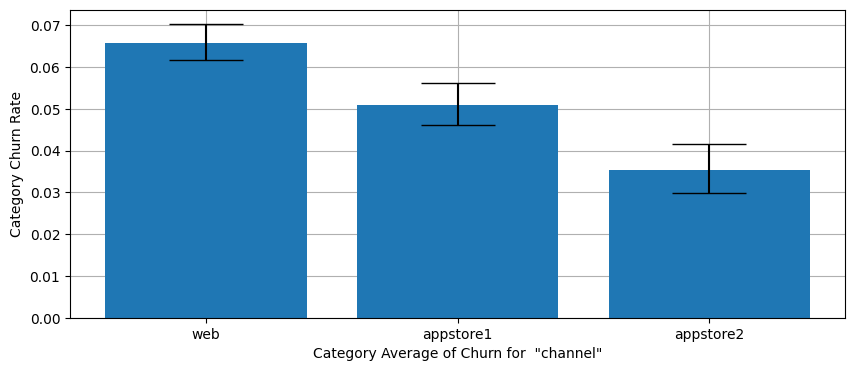

In [57]:
tmp = category_churn_summary(df, "channel")
category_churn_plot(tmp, "channel").show()

In [58]:
data = prepare_category_data(df, ["country"])
tmp = category_churn_summary(df, "country")
cols = tmp.columns[-4:]

with pd.option_context('display.max_colwidth', 120, "precision", 4):
    display(
        tmp.head(10)
        # tmp.style.format({col: "{:,.4%}".format for col in cols})
    )

,is_churn_sum,is_churn_mean,data_count,data_ratio,lower_interval,higher_interval,lower_diff,higher_diff
country,,,,,,,,
CN,190,0.0514,3697,0.1512,0.0447,0.0590,0.0067,0.0076
US,210,0.0570,3682,0.1506,0.0500,0.0650,0.0070,0.0080
BR,63,0.0502,1255,0.0513,0.0394,0.0637,0.0108,0.0135
JP,59,0.0481,1226,0.0501,0.0375,0.0616,0.0106,0.0135
CA,48,0.0466,1031,0.0422,0.0353,0.0612,0.0113,0.0146
IN,66,0.0641,1030,0.0421,0.0507,0.0807,0.0134,0.0166
AU,55,0.0537,1024,0.0419,0.0415,0.0693,0.0122,0.0156
DE,64,0.0662,967,0.0396,0.0522,0.0836,0.0140,0.0174
MX,53,0.0552,961,0.0393,0.0424,0.0714,0.0127,0.0163


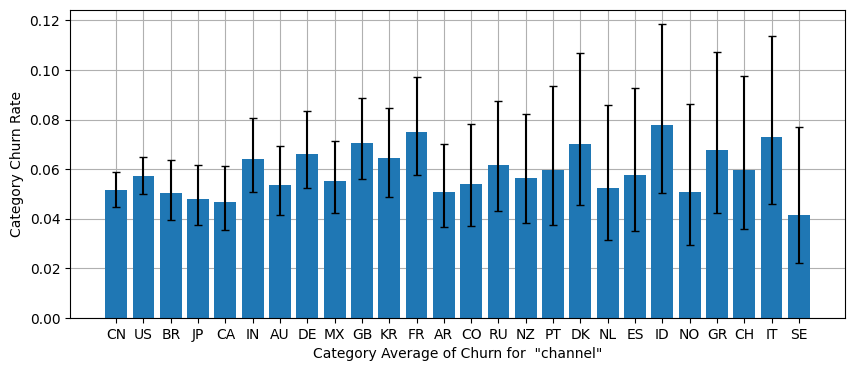

In [59]:
tmp = category_churn_summary(df, "country")
category_churn_plot(tmp, "channel").show()

### Listing 10.3 

- 10.3.2, Cohort analysis with grouped categories

In [60]:
groups = chap10["list3"]["params"]["groups"]
col = chap10["list3"]["params"]["cat_col"]

groups.keys(), col

(dict_keys(['APac', 'Eur', 'LaAm', 'NoAm']), 'country')

In [61]:
def grouped_category_cohorts(
    data: pd.DataFrame, groups_dict: Dict[str, List[str]], category_column: str
 ) -> Tuple[pd.DataFrame, pd.DataFrame]:

    lookup = dict()
    for group, categories in groups_dict.items():
        for cat in categories: 
            lookup[cat] = group

    churn_data = prepare_category_data(data, [category_column])
    
    # replace category name with the category's group name
    group_col = f"{category_column}_group"
    group_churn_data = churn_data.assign(
        **{group_col: churn_data[category_column].map(lookup).fillna("-na-")}
    ).drop(category_column, axis=1)
    
    summary = category_churn_summary(group_churn_data, group_col)
    
    return summary, group_churn_data

,is_churn_sum,is_churn_mean,data_count,data_ratio,lower_interval,higher_interval,lower_diff,higher_diff
country_group,,,,,,,,
-na-,336,0.052533,6396,0.261595,0.047329,0.058274,0.005204,0.005741
Eur,344,0.064796,5309,0.217137,0.058484,0.071737,0.006312,0.006941
NoAm,258,0.054742,4713,0.192761,0.048603,0.061607,0.006139,0.006864
APac,269,0.057651,4666,0.190838,0.051320,0.064710,0.006331,0.007059
LaAm,176,0.052288,3366,0.137669,0.045265,0.060331,0.007023,0.008044


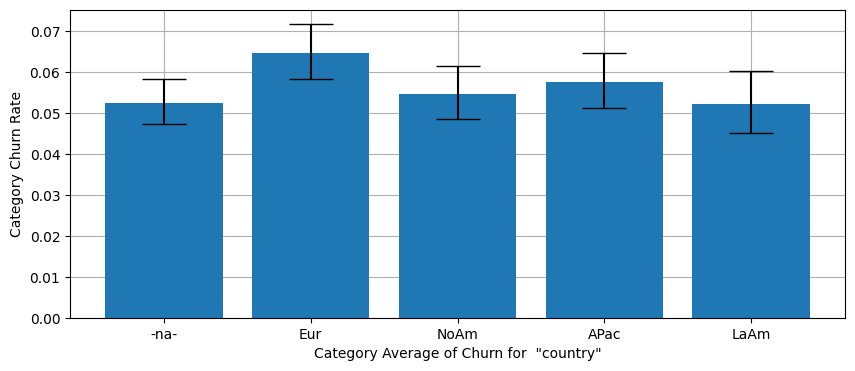

In [62]:
tmp, _ = grouped_category_cohorts(df, groups, "country")
display(tmp)
category_churn_plot(tmp, "country").show()

Notes:

- No significant difference among the regions in terms of churn ratio
- Since the confidence intervals overlap with other regions

### Listing 10.4 Dummy Variable

- 10.5.1, Converting text fields to dummy variables

In [29]:
groups_country = chap10["list4"]["params"]["groups"]["country"]
groups_country.keys()

dict_keys(['APac', 'Eur', 'LaAm', 'NoAm'])

In [ ]:
import pandas as pd

from fightchurn.listings.chap10.listing_10_3_grouped_category_cohorts import group_category_column

def dummy_variables(data_set_path, groups={},current=False):

    raw_data = pd.read_csv(data_set_path, index_col=[0, 1])

    for cat in groups.keys():
        group_category_column(raw_data,cat,groups[cat])

    data_w_dummies = pd.get_dummies(raw_data,dummy_na=True)
    new_cols = sorted(list(set(data_w_dummies.columns).difference(set(raw_data.columns))))
    cat_cols = sorted(list(set(raw_data.columns).difference(set(data_w_dummies.columns))))
    dummy_col_df = pd.DataFrame(new_cols,index=new_cols,columns=['metrics'])
    dummy_col_df.to_csv(data_set_path.replace('.csv', '_dummies_groupmets.csv'))

    if not current:
        new_cols.append('is_churn')
        data_w_dummies.to_csv(data_set_path.replace('.csv', '_xgbdummies.csv'))
    else:
        data_w_dummies.to_csv(data_set_path.replace('current.csv', 'xgbdummies_current.csv'))

    dummies_only = data_w_dummies[new_cols]
    save_path = data_set_path.replace('.csv', '_dummies_groupscore.csv')
    print('Saved dummy variable (only) dataset ' + save_path)
    dummies_only.to_csv(save_path)

    raw_data.drop(cat_cols,axis=1,inplace=True)
    save_path = data_set_path.replace('.csv', '_nocat.csv')
    print('Saved no category dataset ' + save_path)
    raw_data.to_csv(save_path)


### Listing 10.5 Merging

- 10.5.3, Combining dummy variables with numeric data

In [23]:
pprint(chap10["list5"])

{'name': 'merge_groups_dummies', 'params': {}}


In [ ]:
import pandas as pd


def merge_groups_dummies(data_set_path):

    dummies_path = data_set_path.replace('.csv', '_dummies_groupscore.csv')
    dummies_df =pd.read_csv(dummies_path,index_col=[0,1])
    dummies_df.drop(['is_churn'],axis=1,inplace=True)

    groups_path = data_set_path.replace('.csv', '_nocat_groupscore.csv')
    groups_df = pd.read_csv(groups_path,index_col=[0,1])

    merged_df= groups_df.merge(dummies_df,left_index=True,right_index=True)
    save_path = data_set_path.replace('.csv', '_groupscore.csv')
    merged_df.to_csv(save_path)
    print('Saved merged group score + dummy dataset ' + save_path)

    standard_group_metrics = pd.read_csv(data_set_path.replace('.csv', '_nocat_groupmets.csv'),index_col=0)
    dummies_group_metrics = pd.read_csv(data_set_path.replace('.csv', '_dummies_groupmets.csv'),index_col=0)
    merged_col_df = standard_group_metrics.append(dummies_group_metrics)
    merged_col_df.to_csv(data_set_path.replace('.csv', '_groupmets.csv'))


### Listing 10.7 Rescoring

- 10.6, Segmenting current customers with demographic data 

In [30]:
groups_country = chap10["list7"]["params"]["groups"]["country"]
categories = chap10["list7"]["params"]["categories"]

groups_country.keys(), categories

(dict_keys(['APac', 'Eur', 'LaAm', 'NoAm']), ['channel', 'country'])

In [ ]:
import pandas as pd
from fightchurn.listings.chap7.listing_7_5_fat_tail_scores import transform_fattail_columns, transform_skew_columns
from fightchurn.listings.chap8.listing_8_4_rescore_metrics import score_current_data, group_current_data, reload_churn_data
from fightchurn.listings.chap10.listing_10_4_dummy_variables import dummy_variables

def rescore_wcats(data_set_path,categories,groups):

    current_path = data_set_path.replace('.csv', '_current.csv')
    dummy_variables(current_path,groups, current=True)
    current_dummies = reload_churn_data(data_set_path,'current_dummies_groupscore','10.7',is_customer_data=True)
    align_dummies(current_dummies,data_set_path)

    nocat_path = data_set_path.replace('.csv', '_nocat.csv')
    load_mat_df = reload_churn_data(nocat_path,'load_mat','6.4',is_customer_data=False)
    score_df = reload_churn_data(nocat_path,'score_params','7.5',is_customer_data=False)
    current_nocat = reload_churn_data(data_set_path,'current_nocat','10.7',is_customer_data=True)
    assert set(score_df.index.values)==set(current_nocat.columns.values),"Data to re-score does not match transform params"
    assert set(load_mat_df.index.values)==set(current_nocat.columns.values),"Data to re-score does not match loading matrix"
    transform_skew_columns(current_nocat,score_df[score_df['skew_score']].index.values)
    transform_fattail_columns(current_nocat,score_df[score_df['fattail_score']].index.values)
    scaled_data = score_current_data(current_nocat,score_df,data_set_path)
    grouped_data = group_current_data(scaled_data, load_mat_df,data_set_path)

    group_dum_df = grouped_data.merge(current_dummies,left_index=True,right_index=True)
    group_dum_df.to_csv(data_set_path.replace('.csv','_current_groupscore.csv'),header=True)

    current_df = reload_churn_data(data_set_path,'current','10.7',is_customer_data=True)
    save_segment_data_wcats(grouped_data,current_df,load_mat_df,data_set_path, categories)


def align_dummies(current_data,data_set_path):
    current_groupments=pd.read_csv(data_set_path.replace('.csv','_current_dummies_groupmets.csv'),index_col=0)
    new_dummies = set(current_groupments['metrics'])
    original_groupmets = pd.read_csv(data_set_path.replace('.csv','_dummies_groupmets.csv'),index_col=0)
    old_dummies = set(original_groupmets['metrics'])
    missing_in_old = new_dummies.difference(old_dummies)
    missing_in_new = old_dummies.difference(new_dummies)
    for col in missing_in_new:
        current_data[col]=0.0
    for col in missing_in_old:
        current_data.drop(col,axis=1,inplace=True)


def save_segment_data_wcats(current_data_grouped, current_data, load_mat_df, data_set_path, categories):

    group_cols =  load_mat_df.columns[load_mat_df.astype(bool).sum(axis=0) > 1]
    no_group_cols = list(load_mat_df.columns[load_mat_df.astype(bool).sum(axis=0) == 1])
    no_group_cols.extend(categories)
    segment_df = current_data_grouped[group_cols].join(current_data[no_group_cols])
    segment_df.to_csv(data_set_path.replace('.csv','_current_groupmets_segment.csv'),header=True)


## Modelling

### Listing 8.2 Logistic Regression

- 8.3 Fitting a churn model
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [34]:
pprint(chap8["list2"])

{'name': 'logistic_regression', 'params': {}, 'v1': {'as_retention': False}}


In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
def prepare_data(grouped_data: pd.DataFrame, as_retention: bool  = True) \
    -> Tuple[pd.DataFrame, pd.Series]:
    """Prepare data as X and y, with option to convert churn rate to retention rate"""
    
    X = grouped_data.drop(columns=['is_churn'])
    
    # as churn
    y = grouped_data['is_churn'].astype(int)
    
    # convert y values to retention, n.b. retention rate + churn rate = 1
    if as_retention: 
        # `is_churn = False` converted to `is_retained = True`
        y = np.subtract(1, y).rename("is_retained")
    
    return X, y
X, y = prepare_data(grouped_scores, as_retention=True)
X.shape, y.shape, y.name

((24450, 13), (24450,), 'is_retained')

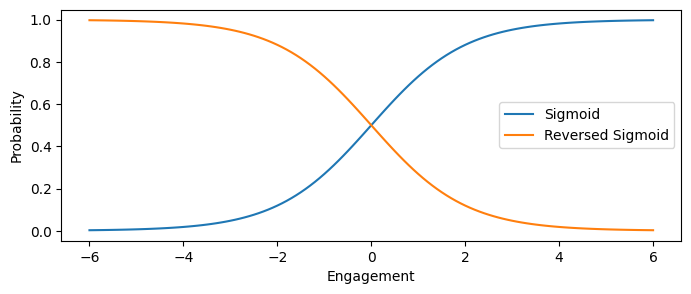

In [37]:
import matplotlib.pyplot as plt

def sigmoid(x: npt.NDArray, rev: bool = False) -> npt.NDArray:
    """S (Sigmoid) curve with logistic, with optional reversed argument"""
    
    # regular shape of sigmoid function, from low to high
    probs =  1.0 / (1.0 + np.exp(-x))
    if rev: 
    # reversed shape of sigmoid, from high to low
        return 1 - probs
        
    return probs

x = np.arange(-6, 6.1, 0.1) # engagement values, from -6 to +6
y = sigmoid(x); rev_y = sigmoid(x, rev=True)

plt.subplots(figsize=(8, 3))
plt.plot(x, y, label="Sigmoid")
plt.plot(x, rev_y, label="Reversed Sigmoid")
plt.xlabel("Engagement"); plt.ylabel("Probability"); plt.legend()
plt.show()
# the plot shows the sigmoid curve and reversed sigmoid curve
# sigmoid curve should be about retention, i.e. increase engagement will increase retetenion probabilty
# reversed sigmoid curve can be interpreted as: increase engagement will reduce churn probablity
# and average engaged user (total engagement = 0) should have 0.5 for both retention and churn probabilty

In [38]:
def calculate_retention_impacts(model: LogisticRegression) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    logistict regression model is: logit(p) = β0 + β1x1 + β2x2 + ... + βnxn
    where 
        β0 is the bias (intercept) term 
        β1...βn are the weights (coefficients)
    
    N.B. the give scored group metrics (X) have been processed to have mean=0 and std=1
    
    OUTPUTS:
      metric_retain_impacts - marginal probability for a metric having 1 std higher than average
      average_retain_prob - probability of retention for an average observation (all metric have value = 0)
    """
    
    n_feat = model.n_features_in_
    coefs = model.coef_[0]
    intercept = model.intercept_
    
    # Average observation is when every metric equals to mean (0), i.e. x1...xn are all 0
    average_obs =  np.zeros((n_feat, ))
    average_retain_prob = sigmoid(np.dot(average_obs, coefs) + intercept)
    
    # Only one metric has value=1, others are 0
    # n.b. since std=1, it also means the observation is 1 std higher than average on that given metric
    only_one_metric_obs = pd.DataFrame(np.eye(n_feat)) # each column is a metric group, each row is a pseudo observation
    metric_retain_probs = []
    for idx, row in only_one_metric_obs.iterrows():
        metric_retain_probs.append(sigmoid(np.dot(row.values, coefs) + intercept))
    metric_retain_probs = np.array(metric_retain_probs)
    
    # For each metric, get its marginal impact on retention probabilty, as the difference to average
    # n.b. since data is 1 std higher than average, it's 1 std impact
    metric_retain_impacts = metric_retain_probs.ravel() - average_retain_prob
    
    return metric_retain_impacts, average_retain_prob

In [39]:
def save_regression_summary(model: LogisticRegression, cluster_groups: pd.DataFrame) -> pd.DataFrame:
    
    one_stdev_impact, average_retain = calculate_retention_impacts(model)
    
    model_summary = pd.DataFrame.from_dict({
        'group_metric_or_offset':  np.append(cluster_groups.index,'offset'), 
        'weight': np.append(model.coef_[0], model.intercept_), 
        'metric_retention_marginal_impact' : np.append(one_stdev_impact, average_retain), 
        'group_metrics' : np.append(cluster_groups.metrics, '(baseline)')
    })
    
    return model_summary

def save_dataset_predictions(model: LogisticRegression, X: pd.DataFrame) -> pd.DataFrame:
    
    preds = model.predict_proba(X)
    predictions = pd.DataFrame(
        preds, index=X.index, columns=['churn_prob','retain_prob']
        # preds has two columns, class=0 and class=1
    )
    
    return predictions

In [40]:
def logistic_regression(grouped_data, cluster_groups, as_retention=True):
    
    # get X and y as training data
    # default to convert to is_retained
    X, y = prepare_data(grouped_data, as_retention=as_retention)
    
    # fit model with training data
    model = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True)
    model.fit(X, y)
    
    # export summary
    summary = save_regression_summary(model, cluster_groups)
    # export predictions
    preds = save_dataset_predictions(model, X)
    
    return (X, y), model, summary, preds

In [41]:
(X, y), model, model_summary, predictions = logistic_regression(
    grouped_scores, groups, as_retention=True
)
model

LogisticRegression(penalty='l1', solver='liblinear')

In [42]:
np.c_[X.columns, model.coef_[0].round(6)]
# each model coefficient is the "wegiht" of a metric group, 
# multiply together than you get total engagement for a given observation
# then the total engagement is converted to probablity with sigmoid function

array([['metric_group_0', 0.336886],
       ['metric_group_1', 0.675152],
       ['newfriend_pcnt_chng', 0.119292],
       ['unfriend_per_newfriend', -0.302779],
       ['days_since_newfriend', 0.201132],
       ['unfriend_per_month', -0.124779],
       ['post_per_message', 0.0],
       ['newfriend_per_month', 0.230736],
       ['adview_per_post', -0.46564],
       ['like_per_post', 0.218957],
       ['dislike_per_month', -0.007729],
       ['dislike_pcnt', -0.154716],
       ['reply_per_message', -0.026795]], dtype=object)

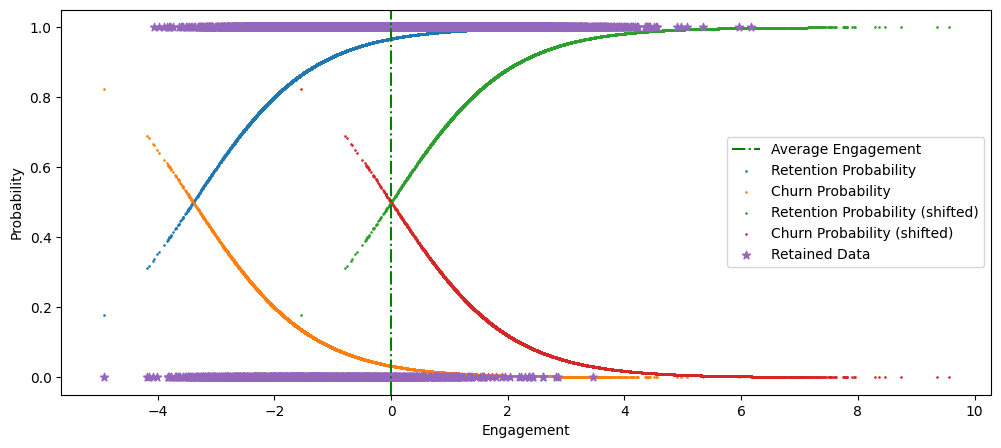

In [43]:
# plot to understand the relationships
engagements = np.dot(X.values, model.coef_[0])
retention_probs = sigmoid(engagements + model.intercept_, rev=False)
# churn_probs = sigmoid(engagements + model.intercept_, rev=True)
churn_probs = 1 - retention_probs # same as above

fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(x=engagements, y=retention_probs, s=.8, label="Retention Probability")
ax.scatter(x=engagements, y=churn_probs, s=.8, label="Churn Probability")

ax.scatter(x=engagements + model.intercept_, y=retention_probs, s=.8, label="Retention Probability (shifted)")
ax.scatter(x=engagements + model.intercept_, y=churn_probs, s=.8, label="Churn Probability (shifted)")

ax.scatter(x=engagements, y=y, marker="*", label="Retained Data")
ax.axvline(x=0, color="green", linestyle="-.", label="Average Engagement")
ax.set_xlabel("Engagement"); ax.set_ylabel("Probability")
ax.legend()
fig.show()

Notes 

- By default, the logistict function (`sigmoid`) is expecting dot product on "X" and "coefficients" plus "intercept" term
- However, the average retained observations (.5) is not centered around 0
- So introduce the intercept (bias) term to shift the curve
- After shitfing, both retention and churn curves intersected at Engagment=0 and .5 Probabilty
- Plot the data points show that there're some distribution difference on "is_retained" 
  - Higher Engagement kind of correlated with more "is_retained"

In [22]:
data = prepare_category_data(df, ["channel"])
tmp = category_churn_summary(data, "channel")

with pd.option_context('display.max_colwidth', 120, "precision", 4):
    display(
        tmp
        # tmp.style.format({col: "{:,.4%}".format for col in cols})
    )
# for each channel, each columns means: 
# is_churn_sum: numer of success, 
# is_churn_mean: average churn ratio, 
# channel_count: number of data points  
# lower and higher interval: confidence interval, relative to the is_churn average
# lower and higher diff: gaps between "is_churn mean" and confidence lower/higher intervals (for error bar plotting)

,is_churn_sum,is_churn_mean,channel_count,channel_percent,lower_interval,higher_interval,lower_diff,higher_diff
channel,,,,,,,,
appstore1,380,0.0509,7467,0.3054,0.0461,0.0561,0.0048,0.0052
appstore2,133,0.0353,3771,0.1542,0.0298,0.0416,0.0054,0.0064
web,870,0.0658,13212,0.5404,0.0617,0.0702,0.0041,0.0044


Notes on the weights and retain impacts

- weights
  - positive indicates it's associated with increasing engagement
  - negative indicates that it is associated with decreasing engagement
- retention impacts
  - the difference that it makes to the retention probability 
  - for a customer to be one standard deviation above the average in this metric
  - assuming that all the other metrics are exactly average.
  - if impact is 2%
    - customer who is one standard deviation above average on the given metric 
    - has a forcast retention probablity 2% higher than average retention probability
    - or, 2% less than the average churn probability
    



### Listing 8.4 Rescore Metrics

- Prepare observations data for forecast

In [45]:
ddf.shape

(10793, 16)

In [46]:
def score_current_data(current_data: pd.DataFrame, score_df: pd.DataFrame) -> pd.DataFrame:
    
    # ordering the columns
    current_data = current_data[score_df.index.values]
    
    # scale data with mean and std
    scaled_data = (current_data-score_df['mean'])/score_df['std']
    
    return scaled_data

In [47]:
def group_current_data(scaled_data: pd.DataFrame, load_mat_df: pd.DataFrame) -> pd.DataFrame:
    
    # ordering the columns
    scaled_data = scaled_data[load_mat_df.index.values]
    # matrix multiplication on data and weight matrxi
    grouped_ndarray = np.matmul(scaled_data.to_numpy(), load_mat_df.to_numpy())
    
    # result data ready for forecasting
    current_data_grouped = pd.DataFrame(
        grouped_ndarray, columns=load_mat_df.columns.values, index=scaled_data.index
    )
    
    return current_data_grouped

In [48]:
def transform_skew_columns(data: pd.DataFrame, skew_col_names: List[str]):
    """Inplace update the skewed columns"""
    for col in skew_col_names:
        data[col] = np.log(1.0 + data[col])

def transform_fattail_columns(data: pd.DataFrame, fattail_col_names: List[str]):
    """Inplace update the failtail columns"""
    for col in fattail_col_names:
        data[col] = np.log(data[col] + np.sqrt(np.power(data[col],2) + 1.0))

def rescore_metrics(
    unseen_data: pd.DataFrame, loading_matrix: pd.DataFrame, skew_params: pd.DataFrame
) -> pd.DataFrame:
    """
    Rescore unseen metrics data with training data weight matrix and skewed params dataframe
    
    INPUTS: 
      unseen_data - unseen metrics data 
      loading_matrix - weight matrix on training data, columned by metric groups
      skew_params - metrics skew parameters, indicating whether a scored metric is skewed/fattail or not
    OUTPUT: 
      group_scores - scores of metric groups from unseen data
    """
    
    assert (not "is_churn" in unseen_data.columns.tolist()), "expect data not being labelled with 'is_churn'"
    
    available_metrics = np.sort(unseen_data.columns.values)
    assert np.array_equal(np.sort(loading_matrix.index.values), available_metrics), "Unseen data have different metrics to training data"
    assert np.array_equal(np.sort(skew_params.index.values), available_metrics), "Unseen data have different metrics to training data"
    
    # transform on skewed columns
    transform_skew_columns(
        unseen_data, skew_params.query("skew_score == True").index.tolist()
    )
    # transform on fatail columns
    transform_fattail_columns(
        unseen_data, skew_params.query("fattail_score == True").index.tolist()
    )
    
    # scale unseen data with training data mean and std
    scores = score_current_data(unseen_data, skew_params)
    # group metrics with training data groups
    group_scores = group_current_data(scores, loading_matrix)
    
    # save_segment_data(group_scores, data, loading_matrixdata_set_path)
                                
    return group_scores

In [49]:
ddf_group_scores = rescore_metrics(ddf.copy(), weight_matrix, params)
ddf_group_scores.head()

,metric_group_0,metric_group_1,newfriend_pcnt_chng,unfriend_per_newfriend,days_since_newfriend,unfriend_per_month,post_per_message,newfriend_per_month,adview_per_post,like_per_post,dislike_per_month,dislike_pcnt,reply_per_message
0,-2.184152,-0.208965,-0.201102,-0.286460,5.111508,2.617577,-0.731499,-0.722367,-0.648489,-1.685893,-0.303248,3.896582,-0.238746
1,0.127013,0.816910,1.198929,-0.286460,3.577180,0.068611,-0.767090,0.185821,0.527498,-0.335982,-0.303248,-0.348793,-0.447599
2,1.651049,1.143544,0.638916,-0.131405,2.979928,0.068611,-0.158283,-0.041226,1.110202,1.950692,1.035251,-0.845263,1.439102
3,-0.150154,1.897807,-0.621111,-0.286460,3.882477,0.068611,-0.980165,-0.268273,-0.123453,-0.274016,-0.448409,-0.438988,-0.218667
4,0.406306,1.586780,0.498913,-0.200406,2.042853,1.767922,-0.580766,0.639915,-1.009531,-0.690208,0.122380,-0.447059,-0.300307


In [50]:
def save_segment_data(
    current_data_grouped: pd.DataFrame, current_data: pd.DataFrame, load_mat_df: pd.DataFrame
):
    # columns (group metrics) that have more than one metrics
    group_cols =  load_mat_df.columns[load_mat_df.astype(bool).sum(axis=0) > 1]
    
    # columns that have just one metric (i.e. not group metric)
    no_group_cols = load_mat_df.columns[load_mat_df.astype(bool).sum(axis=0) == 1]
    
    # segmentation dataframe
    segment_df = current_data_grouped[group_cols].join(current_data[no_group_cols]) # join on index
    
    return segment_df

In [51]:
ddf_segments = save_segment_data(ddf_group_scores, ddf.copy(), weight_matrix)
ddf_segments.head()

,metric_group_0,metric_group_1,newfriend_pcnt_chng,unfriend_per_newfriend,days_since_newfriend,unfriend_per_month,post_per_message,newfriend_per_month,adview_per_post,like_per_post,dislike_per_month,dislike_pcnt,reply_per_message
0,-2.184152,-0.208965,0.000,0.000000,24.0,1.333333,0.545455,1.0,0.500000,0.000000,6.0,1.000000,0.181818
1,0.127013,0.816910,1.250,0.000000,9.0,0.333333,0.488372,9.0,1.857143,1.666667,6.0,0.146341,0.116279
2,1.651049,1.143544,0.750,0.142857,6.0,0.333333,1.833333,7.0,2.931818,13.045455,28.0,0.046512,0.708333
3,-0.150154,1.897807,-0.375,0.000000,11.0,0.333333,0.188119,5.0,1.000000,1.789474,5.0,0.128205,0.188119
4,0.406306,1.586780,0.625,0.076923,3.0,1.000000,0.812500,13.0,0.230769,1.061538,10.0,0.126582,0.162500


In [52]:
ddf_segments.shape

(10793, 13)

### Listing 8.5 Churn Prediction

In [53]:
def churn_forecast(unseen_data: pd.DataFrame, logreg_model: LogisticRegression) -> pd.DataFrame:

    predictions = logreg_model.predict_proba(unseen_data.to_numpy())

    predict_df = pd.DataFrame(
        predictions, index=unseen_data.index, columns=['churn_prob', 'retain_prob']
    )
    
    return predict_df

In [54]:
ddf_preds = churn_forecast(ddf_group_scores, model)
ddf_preds.head()

,churn_prob,retain_prob
0,0.079306,0.920694
1,0.008841,0.991159
2,0.004441,0.995559
3,0.004403,0.995597
4,0.004261,0.995739


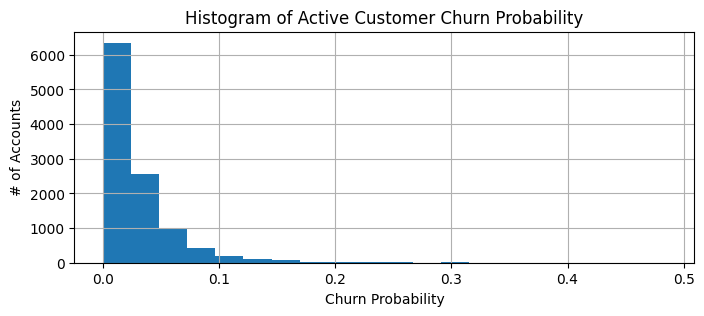

In [55]:
def forecast_histogram(predict_df):
    plt.figure(figsize=[8, 3])
    n, bins,_ = plt.hist(predict_df['churn_prob'].values,bins=20)
    plt.title('Histogram of Active Customer Churn Probability')
    plt.xlabel('Churn Probability')
    plt.ylabel('# of Accounts')
    plt.grid()
    plt.show()
    
    hist_df=pd.DataFrame({'n':n,'bins':bins[1:]})
    return hist_df
result = forecast_histogram(ddf_preds)

In [56]:
result.head(10)

,n,bins
0,6349.0,0.024246
1,2562.0,0.048492
2,1000.0,0.072739
3,414.0,0.096985
4,182.0,0.121231
5,112.0,0.145477
6,65.0,0.169723
7,32.0,0.193970
8,26.0,0.218216
9,16.0,0.242462


#### Export data, model and functions

In [61]:
import pickle

d = {
    "raw_train_data": df.copy(),
    "raw_test_data": ddf.copy(),
    "train_data": grouped_scores,
    "metric_groups": groups,
    "test_data": ddf_group_scores,
    "logreg_model": model,
}

with open("/app/ch8-export.pickle", "wb") as handle:
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Listing 8.6 Outliner clipping

- Set outliner to 99% percentile or 1% percentile

In [58]:
from fightchurn.listings.chap7.listing_7_5_fat_tail_scores import transform_fattail_columns, transform_skew_columns
from fightchurn.listings.chap8.listing_8_4_rescore_metrics import reload_churn_data


def clip_hi_cols(data, hi_vals):
    for col in hi_vals.index.values:
        data.loc[data[col] > hi_vals[col],col] = hi_vals[col]

def clip_lo_cols(data, lo_vals):
    for col in lo_vals.index.values:
        data.loc[data[col] < lo_vals[col],col] = lo_vals[col]


def rescore_metrics(data_set_path):

    current_data = reload_churn_data(data_set_path,'current','8.3',is_customer_data=True)
    load_mat_df = reload_churn_data(data_set_path,'load_mat','6.4',is_customer_data=False)
    score_df = reload_churn_data(data_set_path,'score_params','7.5',is_customer_data=False)
    stats = reload_churn_data(data_set_path,'summarystats','5.2',is_customer_data=False)
    stats.drop('is_churn',inplace=True)
    assert set(score_df.index.values)==set(current_data.columns.values),"Data to re-score does not match transform params"
    assert set(load_mat_df.index.values)==set(current_data.columns.values),"Data to re-score does not match load matrix"
    assert set(stats.index.values)==set(current_data.columns.values),"Data to re-score does not match summary stats"

    clip_hi_cols(current_data, stats['99pct'])
    clip_lo_cols(current_data, stats['1pct'])

    transform_skew_columns(current_data, score_df[score_df['skew_score']].index.values)
    transform_fattail_columns(current_data, score_df[score_df['skew_score']].index.values)

    current_data=current_data[score_df.index.values]
    scaled_data=(current_data-score_df['mean'])/score_df['std']

    scaled_data = scaled_data[load_mat_df.index.values]
    grouped_ndarray = np.matmul(scaled_data.to_numpy(), load_mat_df.to_numpy())

    current_data_grouped = pd.DataFrame(grouped_ndarray,columns=load_mat_df.columns.values, index=current_data.index)

    score_save_path=data_set_path.replace('.csv','_current_groupscore.csv')
    current_data_grouped.to_csv(score_save_path,header=True)
    print('Saving results to %s' % score_save_path)